<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Effortful Retrieval Experiments**

**Author**: Elizabeth Zhong

We will conduct a series of experiments to evaluate memory retrieval performance in CNNs under different conditions of retrieval difficulty. To vary retrieval difficulty, each experiment manipulates a key difficulty variable, interstimulus interval (ISI), criterion level, noise level, and occlusion. To evaluate model performance, each experiment computes classification accuracy, retrieval strength (precision, recall, F1-score), and forgetting rate (change in accuracy over time for previously learned items). We will be using a standard pre-trained `ResNet-18` CNN and fine-tune using the CIFAR-10 image dataset (publicly available via `torchvision.datasets`). 

## **Table of Contents**

1. Notebook Setup
2. Dataset Preparation
3. Experiment Setup
    - Defining the CNN model
    - Abstracted training function
    - Model evaluation functions
4. Experimental Results
    - Experiment 1: Spaced vs. Massed
    - Experiment 2: Criterion Level
    - Experiment 3: Noise Level
    - Experiment 4: Occlusion
5. Interpretation

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **1. Notebook Setup**

In [1]:
# Library imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import random
import matplotlib.pyplot as plt
import time

import torchvision.models as models
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **2. Dataset Preparation**

In [3]:
# Data augmentation for different difficulty manipulations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
# Smaller dataset for preliminary results
subset_size = 0.1 

train_subset, _ = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * subset_size), len(train_dataset) - int(len(train_dataset) * subset_size)])
test_subset, _ = torch.utils.data.random_split(test_dataset, [int(len(test_dataset) * subset_size), len(test_dataset) - int(len(test_dataset) * subset_size)])

prelim_train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
prelim_test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **3. Experiment Setup**

#### **Defining the CNN Model**

In [6]:
def get_pretrained_cnn():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer

_____

#### **Training Function**

Can vary the following:
- Retrieval condition (massed or spaced)
- Dataset noise level
- Occlusion percetage

Returns accuracy and loss across epochs.

In [7]:
def evaluate_batches(model, batch_list):
    model.eval()
    all_preds, all_labels = [], []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for images, labels in batch_list:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * total_correct / total_samples
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return accuracy, precision, recall, f1

In [8]:
def train_and_evaluate(model, data_loader, criterion, optimizer, epochs=10, retrieval_condition="massed", noise_level=0, occlusion_percent=0, spaced_batches=5):
    model.train()
    history = {"accuracy": [], "loss": [], "precision": [], "recall": [], "f1": []}

    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm(total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=True)

        if retrieval_condition == "spaced":
            batch_buffer = []

        for _, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)

            # noise
            if noise_level > 0:
                noise = torch.randn_like(images) * noise_level
                images = torch.clamp(images + noise, 0, 1)

            # occlusion
            if occlusion_percent > 0:
                mask_size = int(32 * occlusion_percent)
                x_start = random.randint(0, 32 - mask_size)
                y_start = random.randint(0, 32 - mask_size)
                images[:, :, x_start:x_start+mask_size, y_start:y_start+mask_size] = 0

            # train model on batch
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # spaced retrieval
            if retrieval_condition == "spaced":
                batch_buffer.append((images, labels))

                if len(batch_buffer) == spaced_batches:
                    acc, precision, recall, f1 = evaluate_batches(model, batch_buffer)
                    history["accuracy"].append(acc)
                    history["precision"].append(precision)
                    history["recall"].append(recall)
                    history["f1"].append(f1)
                    batch_buffer = [] 

            # massed retrieval
            elif retrieval_condition == "massed":
                acc, precision, recall, f1 = evaluate_batches(model, [(images, labels)])
                history["accuracy"].append(acc)
                history["precision"].append(precision)
                history["recall"].append(recall)
                history["f1"].append(f1)

            progress_bar.update(1)

        avg_loss = running_loss / len(data_loader)
        history["loss"].append(avg_loss)

        progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
        progress_bar.close()

    return history

In [9]:
def measure_forgetting_rate(model, test_loader, delay=10):
    # TODO
    ...

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Experimental Results**

_______

### **Experiment 1: Spaced vs. Massed Learning (ISI)**

**Objective**: Test whether spaced learning (inserting delays between learning and retrieval) enhances memory retention in CNNs compared to massed learning (immediate retrieval).

**Training Protocol**

1. Massed Learning: Train CNN on a batch of images and immediately test on the same batch.
2. Spaced Learning: Train CNN on multiple image sets (thus introduce delay) before testing each set in order.

**Benchmark(s)**

1. Compare against standard CNN training accuracy.
2. Measure memory degradation over multiple test intervals.

**Interpretation**

- Spaced retrieval outperforms massed retrieval over time → supports effortful retrieval hypothesis.
- There is no significant difference → spaced learning may not benefit CNNs as it does in human learning.



In [10]:
epochs = 5

In [11]:
# mass learning (easy)
print("Training with Massed Learning")
model_massed, criterion_massed, optimizer_massed = get_pretrained_cnn()
history_massed = train_and_evaluate(model_massed, prelim_train_loader, criterion_massed, optimizer_massed, epochs=5, retrieval_condition="massed")

# spaced learning (harder)
print("\nTraining with Spaced Learning")
model_spaced, criterion_spaced, optimizer_spaced = get_pretrained_cnn()
history_spaced = train_and_evaluate(model_spaced, prelim_train_loader, criterion_spaced, optimizer_spaced, epochs=epochs, retrieval_condition="spaced")

print("Finished learning!")

/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training with Massed Learning


Epoch 5/5: 100%|██████████| 79/79 [00:54<00:00,  1.44it/s, loss=1.4103]
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training with Spaced Learning


Epoch 5/5: 100%|██████████| 79/79 [00:54<00:00,  1.45it/s, loss=1.3995]

Finished learning!


#### **Visualizations**

In [12]:
def plot_training_trends(history_massed, history_spaced):
    metrics = ["accuracy", "loss", "precision", "recall", "f1"]
    titles = {
        "accuracy": "Accuracy Over Epochs",
        "loss": "Loss Over Epochs",
        "precision": "Precision Over Epochs",
        "recall": "Recall Over Epochs",
        "f1": "F1 Score Over Epochs",
    }

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        axes[i].plot(history_massed[metric], label="Massed Learning", marker="o", linestyle="-")
        axes[i].plot(history_spaced[metric], label="Spaced Learning", marker="s", linestyle="--")
        axes[i].set_title(titles[metric])
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    fig.delaxes(axes[-1])
    plt.tight_layout()
    plt.show()

In [13]:
def average_over_epochs(data, num_epochs=5):
    data_length = len(data)
    section_size = data_length // num_epochs

    averaged_data = [np.mean(data[i * section_size:(i + 1) * section_size]) for i in range(num_epochs)]
    return averaged_data

In [14]:
def plot_training_trends(history_massed, history_spaced, num_epochs=5):
    metrics = ["accuracy", "loss", "precision", "recall", "f1"]
    titles = {
        "accuracy": "Average Accuracy Over Epochs",
        "loss": "Average Loss Over Epochs",
        "precision": "Average Precision Over Epochs",
        "recall": "Average Recall Over Epochs",
        "f1": "Average F1 Score Over Epochs",
    }

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        avg_massed = average_over_epochs(history_massed[metric], num_epochs=num_epochs)
        avg_spaced = average_over_epochs(history_spaced[metric], num_epochs=num_epochs)

        axes[i].plot(range(1, num_epochs + 1), avg_massed, label="Massed Learning", marker="o", linestyle="-")
        axes[i].plot(range(1, num_epochs + 1), avg_spaced, label="Spaced Learning", marker="s", linestyle="--")
        axes[i].set_title(titles[metric])
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    fig.delaxes(axes[-1])
    plt.tight_layout()
    plt.show()


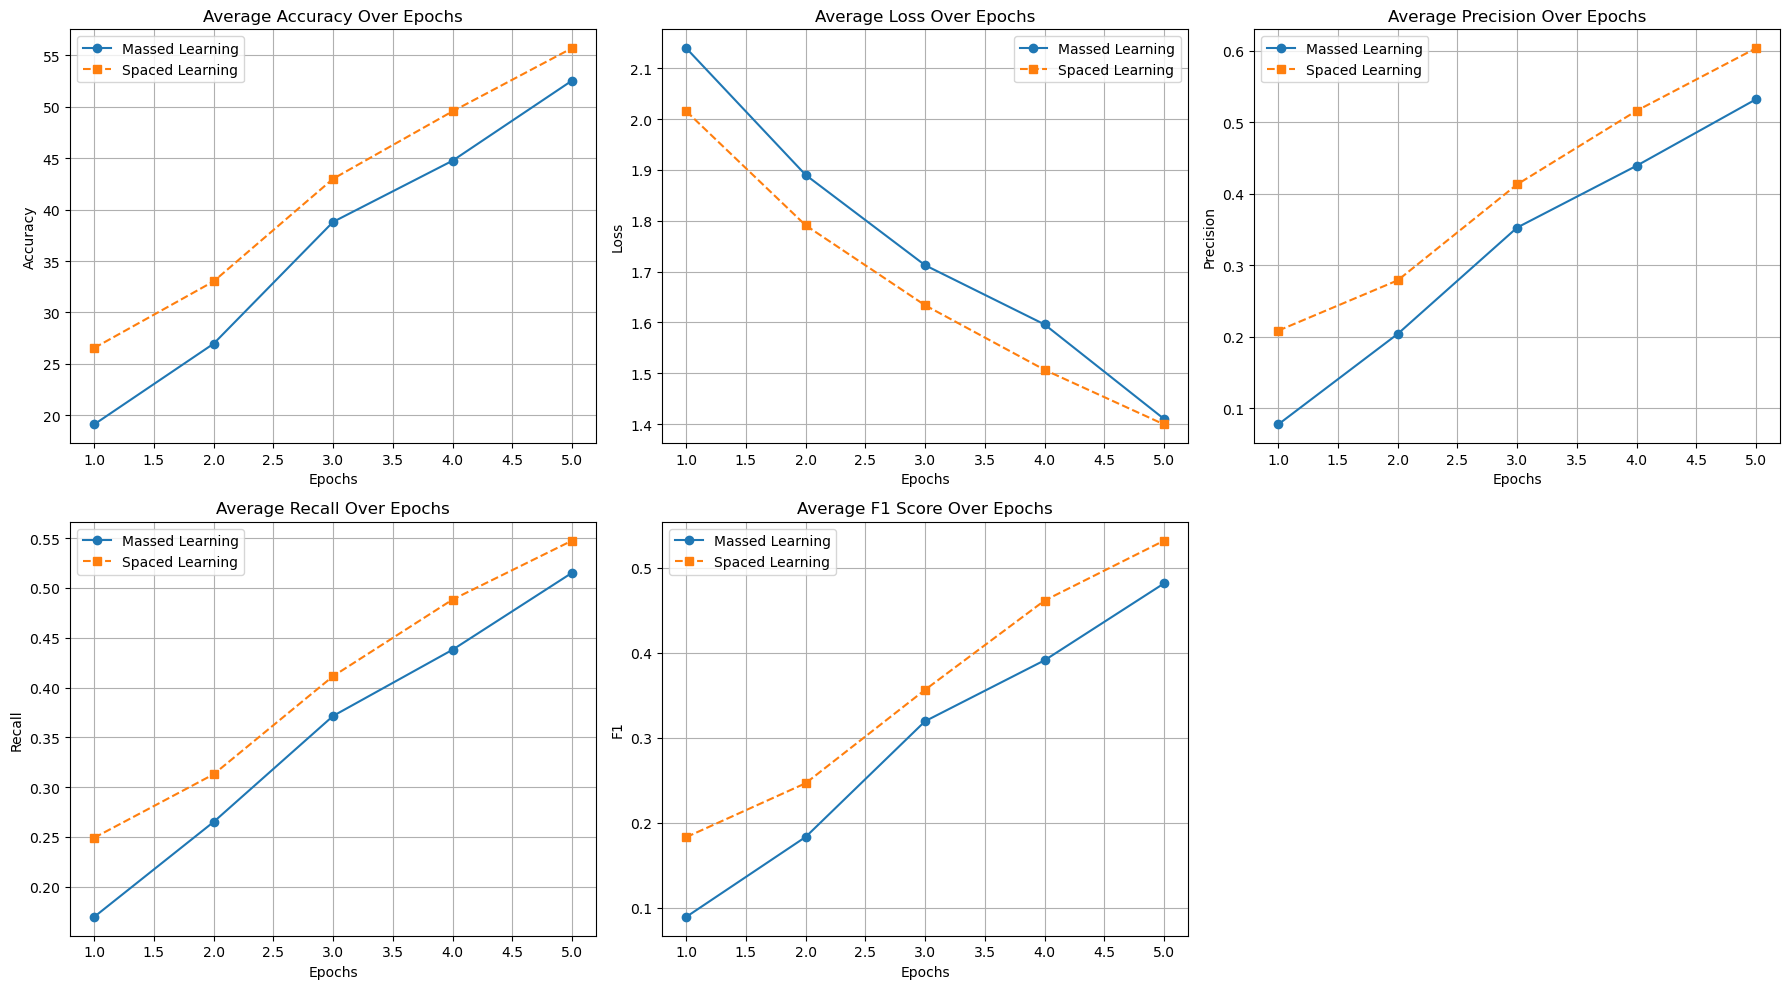

In [15]:
plot_training_trends(history_massed, history_spaced)

_______

### **Experiment 2: Criterion Level (Number of Retrievals Before Dropping)**

**Objective**: Examine whether requiring multiple successful retrievals before dropping an item from training strengthens CNN memory retention.

**Training Protocol**
1. Image must be classified correctly 1 time before dropping.
2. Image must be classified correctly 3 times before dropping.
3. Image must be classified correctly 5 times before dropping.

**Benchmark(s)**: Compare against standard single-pass training

**Interpretation**
- Higher retrieval criteria improve retention → CNNs exhibit similar memory effects as humans.
- No significant improvement → retrieval-based learning might not transfer well to CNNs.


In [16]:
# TODO

_______

### **Experiment 3: Noise Levels in Images**

**Objective**: Investigate how introducing noise into images affects retrieval difficulty and model retention over time.

**Training Protocol**
1. Train CNN on clean images
2. Test under different noise conditions:
    a. Low noise (Gaussian noise, σ=0.1)
    b. Medium noise (σ=0.3)
    c. High noise (σ=0.5)

*Note*: To test under different noise conditions, we will modify the image dataset using `torchvision.transforms`. σ parameters are subject to change.

**Benchmark(s)**
1. Compare against standard CNN performance on clean images.
2. Track degradation trends as noise increases.

**Interpretation**
- Retrieval performance drops significantly with noise →  retrieval difficulty negatively affects CNN retention.
- Model adapts well to noise → CNNs may be robust to effortful retrieval.

In [17]:
# TODO

_______

### **Experiment 4: Occluding Parts of Images**

**Objective**: Test whether CNNs can learn to retrieve images even when parts of the input are missing, mimicking retrieval with incomplete cues in human memory.

**Training Protocol**
1. Train on full images
2. Test under occlusion conditions:
    a. 25% occlusion (randomly block part of the image)
    b. 50% occlusion
    c. 75% occlusion

**Benchmark(s)**: Compare against standard CNN performance on full images.

**Interpretation**
- CNNs struggle with occlusion → retrieval difficulty negatively affects performance.
- CNNs maintain accuracy → effortful retrieval mechanisms might apply.

In [18]:
# TODO

End of notebook :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>